### **Reading data from the file**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

traindata = pd.read_csv('police_killings_train.csv') 
testdata = pd.read_csv('police_killings_test.csv')

 # **Exploratory data analysis (EDA)** 

### **Step 1: Handling missing values in the data set** 




We replaced 37 missing age values in the training data set and 40 missing age values in the testing data set with the **mean of the age** column. The missing values in the race and flee columns were replaced with **the mode of that respective column**. Missing values in the armed column were **dropped** due to their low number. 




In [2]:
print( "The number of null values in the train data set  are:\n", 
      traindata.isnull().sum())
print( "The number of null values in the test data set  are:\n", 
      testdata.isnull().sum())

The number of null values in the train data set  are:
 id                          0
name                        0
date                        0
manner_of_death             0
armed                       6
age                        37
gender                      0
race                       91
city                        0
state                       0
signs_of_mental_illness     0
threat_level                0
flee                       27
body_camera                 0
dtype: int64
The number of null values in the test data set  are:
 id                           0
name                         0
date                         0
manner_of_death              0
armed                        3
age                         40
gender                       0
race                       104
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        38
body_camera                  0
dtype: int64


In [2]:
traindata['age'].fillna((traindata['age'].mean()), inplace=True)
testdata['age'].fillna((testdata['age'].mean()), inplace=True)

traindata['race'].fillna(traindata['race'].mode()[0], inplace=True)
testdata['race'].fillna(testdata['race'].mode()[0], inplace=True)

traindata['flee'].fillna(traindata['flee'].mode()[0], inplace=True)
testdata['flee'].fillna(testdata['flee'].mode()[0], inplace=True)

traindata = traindata.dropna(how='any', subset=['armed'])
testdata = testdata.dropna(how='any', subset=['armed'])

traindata_unmerged = traindata
testdata_unmerged = testdata

### **Step 2: Merge the optional datasets**

First we merged the four optional data sets: education, poverty, income, and share_race_by_city on the columns "city" and "geographic area." Before merging the datasets, we used interpolation to fill the missing values. There were several discrepencies in the number of rows between the datasets. This lead to several missing values. We used interpolation again to fill these missing values. 
The combined data set was merged with our original training and testing data set, in order to incorporate more features into our model. We filled each missing value with the mean of its respective column in both the training and the testing datasets.

In [3]:
education = pd.read_csv('education.csv', encoding='unicode_escape')
income = pd.read_csv('income.csv', encoding='unicode_escape')
poverty = pd.read_csv('poverty.csv', encoding='unicode_escape')
share_race_by_city = pd.read_csv('share_race_by_city.csv', encoding='unicode_escape')

education.columns = education.columns.str.lower()
income.columns = income.columns.str.lower()
poverty.columns = poverty.columns.str.lower()
share_race_by_city.columns = share_race_by_city.columns.str.lower()

education['percent_completed_hs'] = pd.to_numeric(education['percent_completed_hs'], errors='coerce')
income['median income'] = pd.to_numeric(income['median income'], errors='coerce')
poverty['poverty_rate'] = pd.to_numeric(poverty['poverty_rate'], errors='coerce')

share_race_by_city['share_white'] = pd.to_numeric(share_race_by_city['share_white'], errors='coerce')
share_race_by_city['share_black'] = pd.to_numeric(share_race_by_city['share_black'], errors='coerce')
share_race_by_city['share_native_american'] = pd.to_numeric(share_race_by_city['share_native_american'], errors='coerce')
share_race_by_city['share_asian'] = pd.to_numeric(share_race_by_city['share_asian'], errors='coerce')
share_race_by_city['share_hispanic'] = pd.to_numeric(share_race_by_city['share_hispanic'], errors='coerce')

education['percent_completed_hs'] = education['percent_completed_hs'].interpolate()
income['median income'] = income['median income'].interpolate()
poverty['poverty_rate'] = poverty['poverty_rate'].interpolate()

share_race_by_city['share_white']= share_race_by_city['share_white'].interpolate()
share_race_by_city['share_black'] = share_race_by_city['share_black'].interpolate()
share_race_by_city['share_native_american'] = share_race_by_city['share_native_american'].interpolate()
share_race_by_city['share_asian'] = share_race_by_city['share_asian'].interpolate()
share_race_by_city['share_hispanic'] = share_race_by_city['share_hispanic'].interpolate()

poverty_education = pd.merge(poverty, education, how='left', on=['city', 'geographic area'])

income_share_race_by_city = pd.merge(income, share_race_by_city, how="left", on=['city', 'geographic area'])

income_share_race_by_city['share_white'] = income_share_race_by_city['share_white'].interpolate()
income_share_race_by_city['share_black'] = income_share_race_by_city['share_black'].interpolate()
income_share_race_by_city['share_native_american'] = income_share_race_by_city['share_native_american'].interpolate()
income_share_race_by_city['share_asian'] = income_share_race_by_city['share_asian'].interpolate()
income_share_race_by_city['share_hispanic'] = income_share_race_by_city['share_hispanic'].interpolate()

combined_optional_df = pd.merge(poverty_education, income_share_race_by_city, how="left", on=['city', 'geographic area'])

combined_optional_df['share_white'] = combined_optional_df['share_white'].interpolate()
combined_optional_df['share_black'] = combined_optional_df['share_black'].interpolate()
combined_optional_df['share_native_american'] = combined_optional_df['share_native_american'].interpolate()
combined_optional_df['share_asian'] = combined_optional_df['share_asian'].interpolate()
combined_optional_df['share_hispanic'] = combined_optional_df['share_hispanic'].interpolate()

combined_optional_df['median income'] = combined_optional_df['median income'].interpolate()

traindata = pd.merge(traindata_unmerged, combined_optional_df, how='left', on='city')
traindata['poverty_rate'].fillna((traindata['poverty_rate'].mean()), inplace=True)
traindata['percent_completed_hs'].fillna((traindata['percent_completed_hs'].mean()), inplace=True)
traindata['median income'].fillna((traindata['median income'].mean()), inplace=True)
traindata['share_white'].fillna((traindata['share_white'].mean()), inplace=True)
traindata['share_black'].fillna((traindata['share_black'].mean()), inplace=True)
traindata['share_native_american'].fillna((traindata['share_native_american'].mean()), inplace=True)
traindata['share_asian'].fillna((traindata['share_asian'].mean()), inplace=True)
traindata['share_hispanic'].fillna((traindata['share_hispanic'].mean()), inplace=True)

testdata = pd.merge(testdata_unmerged, combined_optional_df, how='left', on='city')
testdata['poverty_rate'].fillna((testdata['poverty_rate'].mean()), inplace=True)
testdata['percent_completed_hs'].fillna((testdata['percent_completed_hs'].mean()), inplace=True)
testdata['median income'].fillna((testdata['median income'].mean()), inplace=True)
testdata['share_white'].fillna((testdata['share_white'].mean()), inplace=True)
testdata['share_black'].fillna((testdata['share_black'].mean()), inplace=True)
testdata['share_native_american'].fillna((testdata['share_native_american'].mean()), inplace=True)
testdata['share_asian'].fillna((testdata['share_asian'].mean()), inplace=True)
testdata['share_hispanic'].fillna((testdata['share_hispanic'].mean()), inplace=True)

traindata.drop('geographic area', inplace=True,axis=1)
testdata.drop('geographic area', inplace=True,axis=1)

### **Step 3: Creating new features**

We create new columns year, month, day using the date columns. This would be make our data set more organized. We drop the date column. 

In [4]:
traindata['year'] = pd.DatetimeIndex(traindata['date']).year
testdata['year'] = pd.DatetimeIndex(testdata['date']).year

traindata['month'] = pd.DatetimeIndex(traindata['date']).month
testdata['month'] = pd.DatetimeIndex(testdata['date']).month

traindata['day'] = pd.DatetimeIndex(traindata['date']).day
testdata['day'] = pd.DatetimeIndex(testdata['date']).day

traindata.drop('date', axis=1,inplace=True)
testdata.drop('date', axis=1,inplace=True)

 # **EDA questions** 

### **1.** Which state has the most fatal police shootings? Which city is the most dangerous?

In [6]:
traindata['state'].value_counts().head(1)

CA    338
Name: state, dtype: int64

Thus **California** has the most fatal police shootings with 340. 

In [7]:
traindata['city'].value_counts().head(1)

Los Angeles    31
Name: city, dtype: int64

**Los Angeles** is found to be the most dangerous city as it has 31 police shootings.


### **2.** What is the most common way of being armed?

In [8]:
print(traindata["armed"].value_counts())

gun                    1114
knife                   304
unarmed                 148
vehicle                 125
undetermined             91
                       ... 
straight edge razor       1
metal object              1
beer bottle               1
pole and knife            1
pipe                      1
Name: armed, Length: 65, dtype: int64


Thus, **gun** is the most common way of being armed.

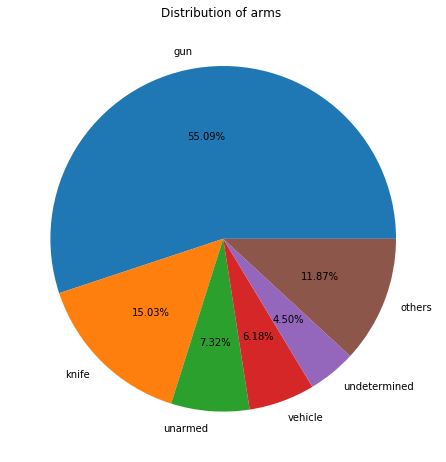

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
plt.title('Distribution of arms ')
arms = ['gun', 'knife', 'unarmed', 'vehicle', 'undetermined','others' ]
shootings = [1114,304,148,125,91,240]
ax.pie(shootings, labels = arms,autopct='%1.2f%%')
plt.show()

### **3.** Compare the total number of people killed per race. Compare the number of people killed per race as a proportion of respective races. What difference do you observe?

---




In [10]:
traindata['race'].value_counts()

W    1085
B     504
H     347
A      31
O      28
N      27
Name: race, dtype: int64

In [11]:
Wdata = traindata[traindata['race'] == 'W']
print("Total White race people killed are :", Wdata.shape[0])
Bdata = traindata[traindata['race'] == 'B']
print("Total Black or African American people killed are :", Bdata.shape[0])
Hdata = traindata[traindata['race'] == 'H']
print("Total Hispanic or Latino people killed are :", Hdata.shape[0])
Adata = traindata[traindata['race'] == 'A']
print("Total Asian killed are :", Adata.shape[0])
Odata = traindata[traindata['race'] == 'O']
print("Total Other race people killed are :", Odata.shape[0])
Ndata = traindata[traindata['race'] == 'N']
print("Total Native Hawaiian people killed are :", Ndata.shape[0])

Total White race people killed are : 1085
Total Black or African American people killed are : 504
Total Hispanic or Latino people killed are : 347
Total Asian killed are : 31
Total Other race people killed are : 28
Total Native Hawaiian people killed are : 27


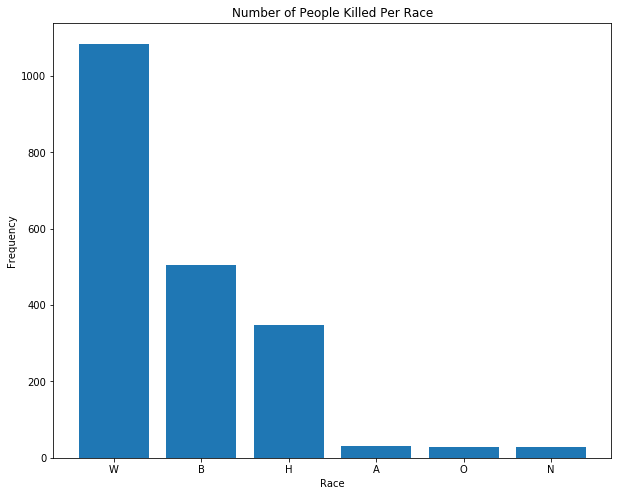

In [12]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.bar(traindata['race'].value_counts().index, traindata['race'].value_counts().values)
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Number of People Killed Per Race')
plt.show()

### **4.** What is the age distribution of the victims? Compare age distribution of different races?

Age distribution of entire data set is as follows :

In [13]:
print(traindata["age"].describe())
print("Mode of the data",traindata["age"].mode())

count    2022.000000
mean       36.565233
std        12.776698
min         6.000000
25%        27.000000
50%        35.000000
75%        45.000000
max        86.000000
Name: age, dtype: float64
Mode of the data 0    31.0
dtype: float64


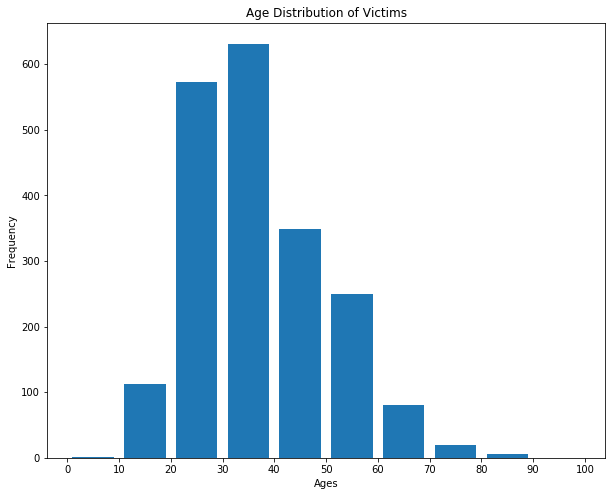

In [14]:
plt.rcParams['figure.figsize'] = (10, 8)
population_ages = traindata['age']
bins = [0,10,20,30,40,50,60,70,80,90,100]
plt.hist(population_ages, bins, histtype='bar', rwidth=0.8)
plt.xlabel('Ages')
plt.ylabel('Frequency')
plt.title('Age Distribution of Victims')
plt.xticks(bins)
plt.show()

Race specific age distribution is as follows:


**White race (W)** 


In [15]:
print(Wdata["age"].describe())

count    1085.000000
mean       40.175828
std        13.248466
min         6.000000
25%        30.000000
50%        38.000000
75%        50.000000
max        86.000000
Name: age, dtype: float64


**Black or African american race (B)**

In [16]:
print(Bdata["age"].describe())

count    504.000000
mean      31.569572
std       10.886775
min       13.000000
25%       24.000000
50%       30.000000
75%       37.000000
max       77.000000
Name: age, dtype: float64


**Hispanic or Latino race (H)**

In [17]:
print(Hdata["age"].describe())

count    347.000000
mean      33.148368
std       10.612906
min       14.000000
25%       25.000000
50%       32.000000
75%       39.000000
max       80.000000
Name: age, dtype: float64


**Asian race (A)**

In [18]:
print(Adata["age"].describe())

count    31.000000
mean     37.567117
std      11.518399
min      15.000000
25%      29.500000
50%      36.580613
75%      44.000000
max      61.000000
Name: age, dtype: float64


**Native Hawaiian race (N)**


In [19]:
print(Ndata["age"].describe())

count    27.000000
mean     31.111111
std       8.266398
min      19.000000
25%      25.000000
50%      31.000000
75%      36.000000
max      49.000000
Name: age, dtype: float64


**Other race (O)**

In [20]:
print(Odata["age"].describe())

count    28.000000
mean     33.071429
std      11.148588
min      18.000000
25%      26.500000
50%      29.500000
75%      41.250000
max      56.000000
Name: age, dtype: float64


The common characteristic between all of the distributions was that the age range of most of the victims was late twenties to early forties. The highest mean age was seen among the white race (40 years). The mean age of the other races was around the same range (33 years- 37 years). The youngest person killed was found to be 6 years old and the oldest person killed in our data set was in the upper 80’s. The most frequently occurring age in our data set was found to be 31 years. 

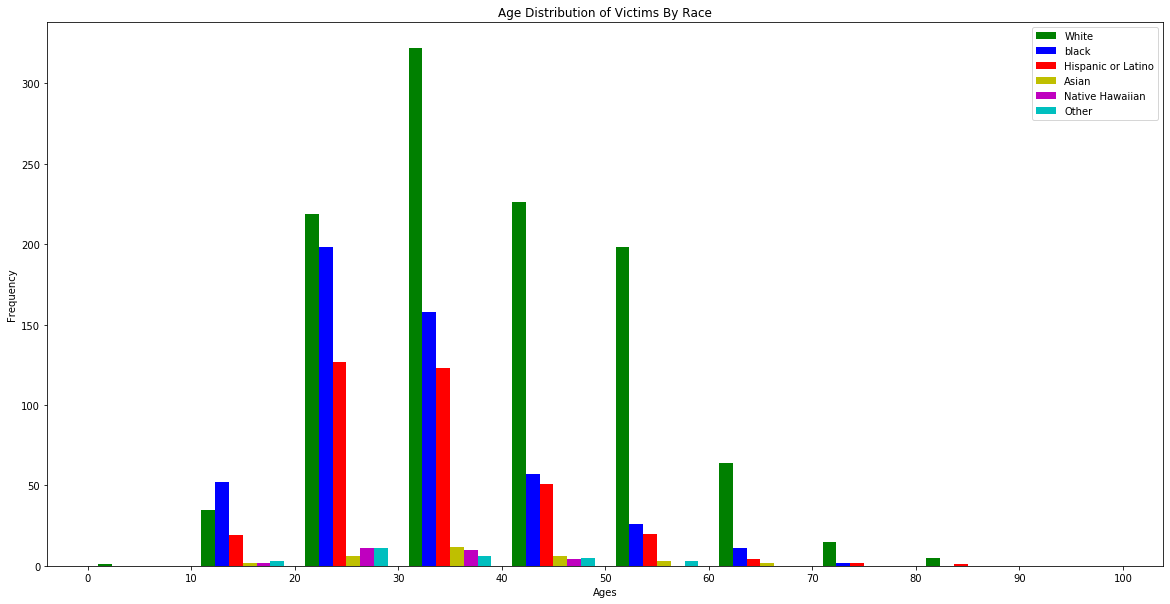

In [21]:
plt.rcParams['figure.figsize'] = (20, 10)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.hist([Wdata["age"], Bdata["age"], Hdata["age"], Adata["age"], Ndata["age"], Odata["age"]], bins, histtype='bar', rwidth=0.8, color=['g', 'b', 'r', 'y', 'm', 'c'], 
         label = ['White', 'black', 'Hispanic or Latino', 'Asian', 'Native Hawaiian', 'Other'])
plt.xlabel('Ages')
plt.ylabel('Frequency')
plt.title('Age Distribution of Victims By Race')
plt.xticks(bins)
plt.legend()
plt.show()

### **5.**  Distribution of race by year 

Number of killings in 2015:  990
Number of killings in 2016:  959
Number of killings in 2017 73
2015 Killings
W    523
B    257
H    172
O     15
A     14
N      9
Name: race, dtype: int64
2016 Killings
W    526
B    231
H    160
N     16
A     15
O     11
Name: race, dtype: int64
2017 Killings
W    36
B    16
H    15
A     2
N     2
O     2
Name: race, dtype: int64


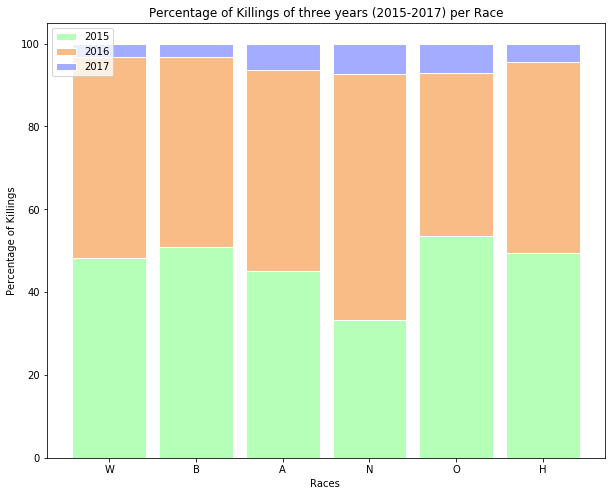

In [22]:
data2015 = traindata[traindata['year'] == 2015]
data2016 = traindata[traindata['year'] ==  2016]
data2017 = traindata[traindata['year'] == 2017]
print("Number of killings in 2015: ", data2015.shape[0])
print("Number of killings in 2016: ", data2016.shape[0])
print("Number of killings in 2017", data2017.shape[0])

print("2015 Killings")
print(data2015['race'].value_counts())
print("2016 Killings")
print(data2016['race'].value_counts())
print("2017 Killings")
print(data2017['race'].value_counts())

fig = plt.figure(figsize=(10,8))
time=['2015','2016','2017']
r = [0,1,2,3,4,5]
ourdata = {'daybar': [523,257,14,9,15,172], 'eveningbar':[526,231,15,16,11,160] ,'nightbar': [36,16,2,2,2,15]}
df = pd.DataFrame(ourdata)

totals = [i+j+k for i,j,k in zip(df['daybar'], df['eveningbar'], df['nightbar'])]
daybar = [i / j * 100 for i,j in zip(df['daybar'], totals)]
eveningbar = [i / j * 100 for i,j in zip(df['eveningbar'], totals)]
nightbar = [i / j * 100 for i,j in zip(df['nightbar'], totals)]
barWidth = 0.85
names = names = ["W","B","A","N","O","H"]
plt.bar(r, daybar, color='#b5ffb9', edgecolor='white', width=barWidth)
plt.bar(r, eveningbar, bottom=daybar, color='#f9bc86', edgecolor='white', width=barWidth)
plt.bar(r, nightbar, bottom=[i+j for i,j in zip(daybar, eveningbar)], color='#a3acff', edgecolor='white', width=barWidth)
plt.legend(time,loc=2)
plt.xticks(r, names)
plt.title('Percentage of Killings of three years (2015-2017) per Race')
plt.xlabel("Races ")
plt.ylabel("Percentage of Killings")
plt.show()

The highest number of police killings took place in 2015. 2017 saw the lowest number of killings. Highest percentage of white race and native hawaiian and Asian killings took place in 2016. On the contrary, 2015 saw the highest percentages of black, Hispanic , other race killings. 


### **6.**  How does the number of police officers wearing body cameras vary by race?

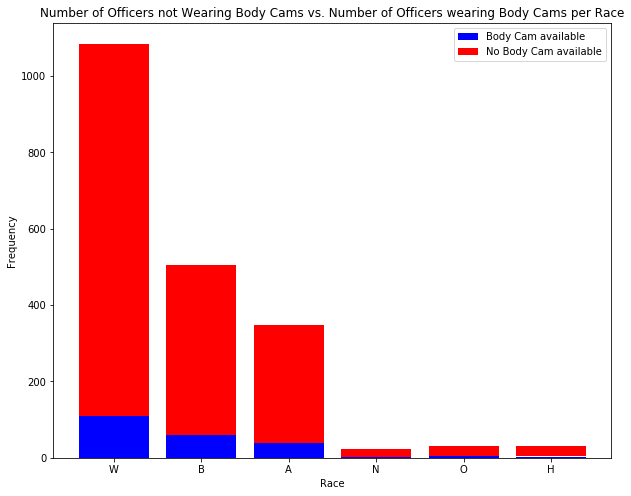

The percentage of police shootings where a body camera was not present was 0.890702274975272
The percentage of police shootings where a body camera was present was 0.109297725024728


In [5]:
plt.rcParams['figure.figsize'] = (10, 8)
traindata_bodycams = traindata[traindata['body_camera'] == True]
traindata_nobodycams = traindata[traindata['body_camera'] == False]
plt.bar(traindata_bodycams['race'].value_counts().index, traindata_bodycams['race'].value_counts().values, label='Body Cam available', color='#0000FF')
plt.bar(traindata_nobodycams['race'].value_counts().index, traindata_nobodycams['race'].value_counts().values, label='No Body Cam available', color='#FF0000',
        bottom=traindata_bodycams['race'].value_counts().values)
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Number of Officers not Wearing Body Cams vs. Number of Officers wearing Body Cams per Race')
tickValues = [0, 1, 2, 3, 4, 5]
names = ["W","B","A","N","O","H"]
plt.xticks(ticks = tickValues, labels = names)
plt.legend()
plt.show()

print("The percentage of police shootings where a body camera was not present was " + str((((traindata_nobodycams.shape)[0])/((traindata.shape)[0]))))
print("The percentage of police shootings where a body camera was present was " + str(((traindata_bodycams.shape)[0])/((traindata.shape)[0])))

### **7.**  How was the distribution of the victims identified with a mental illness between the different races?

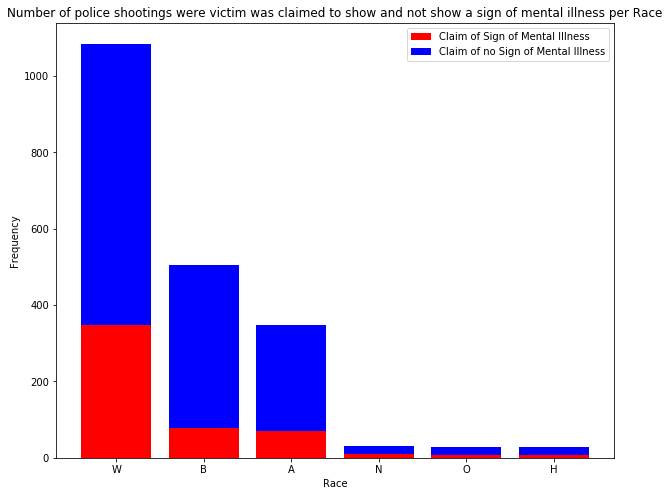

In [24]:
plt.rcParams['figure.figsize'] = (10, 8)
traindata_mental = traindata[traindata['signs_of_mental_illness'] == True]
traindata_nomental = traindata[traindata['signs_of_mental_illness'] == False]
plt.bar(traindata_mental['race'].value_counts().index, traindata_mental['race'].value_counts().values, label='Claim of Sign of Mental Illness', color='#FF0000')
plt.bar(traindata_nomental['race'].value_counts().index, traindata_nomental['race'].value_counts().values, label='Claim of no Sign of Mental Illness', color='#0000FF',
        bottom=traindata_mental['race'].value_counts().values)
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Number of police shootings were victim was claimed to show and not show a sign of mental illness per Race')
tickValues = [0, 1, 2, 3, 4, 5]
names = ["W","B","A","N","O","H"]
plt.xticks(ticks = tickValues, labels = names)
plt.legend()
plt.show()

### 8. Signs of mental illness based on Gender

In [25]:
Mdata = traindata[traindata['gender'] == 'M']
Fdata = traindata[traindata['gender'] == 'F']
print("Number of males killed: ", Mdata.shape[0])
print("Number of females killed:",Fdata.shape[0])

Number of males killed:  1938
Number of females killed: 84


A huge disparity can be noticed between the number of femaless and the number of males killed. 
95.8% of our data set consists of males as opposed to 4.2 % females.

#### Signs of Mental Illness

In [26]:
print("Signs of mental illness among Male")
print(Mdata['signs_of_mental_illness'].value_counts())
print("Signs of mental illness among Females")
print(Fdata['signs_of_mental_illness'].value_counts())

Signs of mental illness among Male
False    1452
True      486
Name: signs_of_mental_illness, dtype: int64
Signs of mental illness among Females
False    51
True     33
Name: signs_of_mental_illness, dtype: int64


**Based on the graphs below more percentage of Females killed (almost 40%) were found to exhibit signs of mental illness as compared to males (25%)**

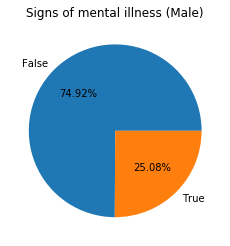

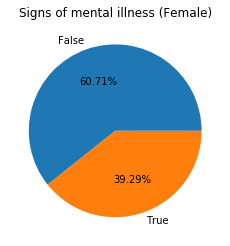

In [27]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
plt.title('Signs of mental illness (Male)')
methods = ['False','True' ]
crimes = Mdata['signs_of_mental_illness'].value_counts()
ax.pie(crimes, labels = methods,autopct='%1.2f%%')
plt.show()

fig = plt.figure(figsize=(3,3))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
plt.title('Signs of mental illness (Female)')
methods = ['False','True' ]
crimes = Fdata['signs_of_mental_illness'].value_counts()
ax.pie(crimes, labels = methods,autopct='%1.2f%%')
plt.show()

# **Data Preprocessing**

We cannot using strings, boolean values, or characters in our models. Here, we prepared our data for our models in part two by assigning each of our categories with corresponding numbers( label encoding )

In [28]:
race_map = {"W":1,"B":2,"A":3,"N":4,"H":6,"O":5, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}

gender_map = {"M":1,"F":2,1:1,2:2}

flee_map = {"Not fleeing":1,"Car":2,"Foot":3,"Other":4,1:1,2:2,3:3,4:4}

threat_level_map = {"attack":1,"other":2,"undetermined":3,1:1,2:2,3:3}

death_map = {"shot":1,"shot and Tasered":2,1:1,2:2}

mental_illness_map = {True:1,False:2,1:1,2:2}

body_camera_map = {True:1,False:2,1:1,2:2}

traindata['race'] = traindata['race'].map(race_map)
testdata['race'] = testdata['race'].map(race_map)

traindata['gender'] = traindata['gender'].map(gender_map)
testdata['gender'] = testdata['gender'].map(gender_map)

traindata['flee'] = traindata['flee'].map(flee_map)
testdata['flee'] = testdata['flee'].map(flee_map)

traindata['threat_level'] = traindata['threat_level'].map(threat_level_map)
testdata['threat_level'] = testdata['threat_level'].map(threat_level_map)

traindata['manner_of_death'] = traindata['manner_of_death'].map(death_map)
testdata['manner_of_death'] = testdata['manner_of_death'].map(death_map)

traindata['signs_of_mental_illness'] = traindata['signs_of_mental_illness'].map(mental_illness_map)
testdata['signs_of_mental_illness'] = testdata['signs_of_mental_illness'].map(mental_illness_map)

traindata['body_camera'] = traindata['body_camera'].map(body_camera_map)
testdata['body_camera'] = testdata['body_camera'].map(body_camera_map)


#ARMED
unique_armed_methods = traindata['armed'].value_counts().index.tolist()
armed_map = {}
for i in range(len(unique_armed_methods)):
  armed_map[unique_armed_methods[i]] = i+1

traindata['armed'] = traindata['armed'].map(armed_map)

unique_armed_methods2 = testdata['armed'].value_counts().index.tolist()
armed_map2 = {}
for i in range(len(unique_armed_methods2)):
  armed_map2[unique_armed_methods2[i]] = i+1
testdata['armed'] = testdata['armed'].map(armed_map2)

#CITY
unique_city_methods = traindata['city'].value_counts().index.tolist()
city_map = {} 

for i in range(len(unique_city_methods)):
  city_map[unique_city_methods[i]] = i+1

traindata['city'] = traindata['city'].map(city_map)

unique_city_methods2 = testdata['city'].value_counts().index.tolist()
city_map2 = {}

for i in range(len(unique_city_methods2)):
  city_map2[unique_city_methods2[i]] = i+1
testdata['city'] = testdata['city'].map(city_map2)

#STATE
unique_state_methods = traindata['state'].value_counts().index.tolist()
state_map = {}

for i in range(len(unique_state_methods)):
  state_map[unique_state_methods[i]] = i+1

traindata['state'] = traindata['state'].map(state_map)
testdata['state'] = testdata['state'].map(state_map)

**Our data is now ready for modelling !**

In [29]:
traindata.head()

,id,name,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,...,percent_completed_hs,median income,share_white,share_black,share_native_american,share_asian,share_hispanic,year,month,day
0,3,Tim Elliot,1,1,53.0,1,3,1036,14,1,...,91.7,81156.5,78.775,4.825,1.325,6.3,14.3,2015,2,1
1,4,Lewis Lee Lembke,1,1,47.0,1,1,227,25,2,...,91.7,81156.5,78.775,4.825,1.325,6.3,14.3,2015,2,1
2,5,John Paul Quintero,2,3,23.0,1,6,101,33,2,...,91.7,81156.5,78.775,4.825,1.325,6.3,14.3,2015,3,1
3,8,Matthew Hoffman,1,6,32.0,1,1,21,1,1,...,91.7,81156.5,78.775,4.825,1.325,6.3,14.3,2015,4,1
4,9,Michael Rodriguez,1,57,39.0,1,6,191,5,2,...,91.7,81156.5,78.775,4.825,1.325,6.3,14.3,2015,4,1


## **Pearson Correlation of features**

This is a heatmap which shows the Pearson correlation coefficeints between our different variables. The **state, age, and city** categories show the highest correlation coefficient with the victim's race. Other features that show interesting correlations with eachother are:
1. Signs of Mental illness and flee (0.2)
2. Threat level and armed (0.17)
3. Year and threat level (0.14)
4. Manner of death and armed(0.16)

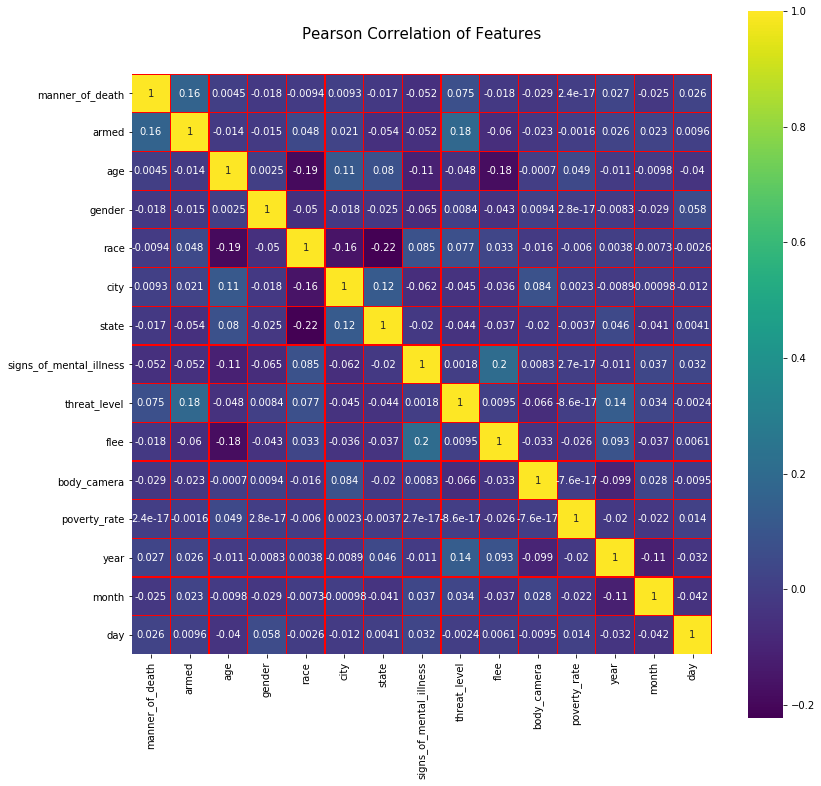

In [30]:
traindata2 = traindata.drop(['name','median income','share_white','share_native_american'
,'share_black','share_asian','share_hispanic','percent_completed_hs','id'],axis=1)
colormap = plt.cm.viridis
plt.figure(figsize=(13,13))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(traindata2.astype(float).corr(),linewidths=0.2,vmax=1.0,
            square=True, cmap=colormap, linecolor='red', annot=True)
plt.show()

# **PREDICTION AND MODELING**

### **1. Classification using Support Vector Machine (SVM)**

Our first step is to import svc from svm. Next let us train our svm model using our training dataset. We use the value of C=1 and the default rbf kernel for our model with the value of gamma set to auto. The next step is to use the trained model to make predictions by specifying our testing data as the parameter.
In order to check the accuracy of our model we compare the predicted output that we got with the testing output that we already have. We check the accuracy for our model with our model's prediction against our dataset’s testing output using a confusion matrix with each column corresponding to a race.


     W  B  A  N  H
W  307  0  0  0  0
B  110  0  0  0  0
A    8  0  0  0  0
N    4  0  0  0  0
H   75  0  0  0  0


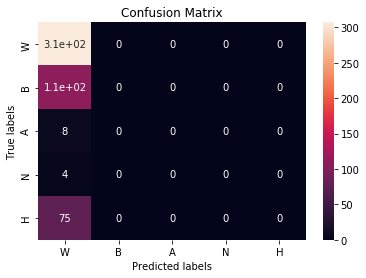

In [31]:
y_train = traindata['race']
X_train = traindata.drop(['race','name'], axis=1)
y_test = testdata['race']
X_test = testdata.drop(['race','name'], axis=1)
model_svc = SVC(gamma='auto',kernel='rbf',C=1)
model_svc = model_svc.fit(X_train,y_train)
y_pred = model_svc.predict(X_test)
confm = np.array(confusion_matrix(y_test,y_pred,labels=[1,2,3,4,6]))
conf_matrix= pd.DataFrame(confm, index=['W', 'B','A','N','H'],columns=['W','B','A','N','H'])
print(conf_matrix)

plt.figure(figsize=(6,4))
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


We now print out a classification report with fields like precision, recall, f1-score and support which give us information about the overall accuracy of our model.

**Precision:** ​Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

**Recall:** Recall is the ratio of correctly predicted positive observations to the all observations in actual class

**F1- score:** This is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.

In [32]:
print(classification_report(y_test,y_pred))
print("Overall Accuracy of the model is :" ,accuracy_score(y_test, y_pred)*100, "%") 

              precision    recall  f1-score   support

           1       0.61      1.00      0.76       307
           2       0.00      0.00      0.00       110
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        75

    accuracy                           0.61       504
   macro avg       0.12      0.20      0.15       504
weighted avg       0.37      0.61      0.46       504

Overall Accuracy of the model is : 60.912698412698404 %


### **2. Classification using Decision Tree Classifier**

A decision tree is supervised learning algorithm. It follows a flowchart-like structure in which  internal node represents a “test” on an attribute, each branch represents the outcome of the test. A leaf node in the tree represents a class label. We continue splitting the tree into nodes , until max_depth has not been reached, or the purity threshold of each leaf node hasnt been reached. The maximum depth of a decision tree can be number of features + 1. In this case we perform classification with decision tree using the value of max_depth as 5. 

     W   B  A  N  O   H
W  207  54  0  0  0  46
B   55  41  0  0  0  14
A    7   0  0  0  0   1
N    1   2  0  0  0   1
O    0   0  0  0  0   0
H   33  12  0  0  0  30


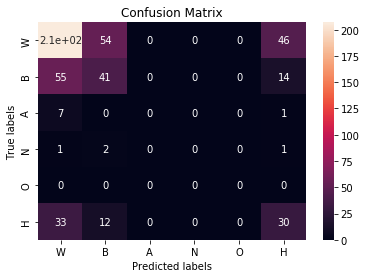

In [33]:
regr_1 = DecisionTreeClassifier(max_depth=5)
regr_1.fit(X_train, y_train)
y_pred = regr_1.predict(X_test)
confm = np.array(confusion_matrix(y_test,y_pred,labels=[1,2,3,4,5,6]))
conf_matrix= pd.DataFrame(confm, index=['W','B','A','N','O','H'],columns=['W','B','A','N','O','H'])
print(conf_matrix)

plt.figure(figsize=(6,4))
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [34]:
print(classification_report(y_test,y_pred))
print("Overall Accuracy of the model is :" ,accuracy_score(y_test, y_pred)*100, "%") 

              precision    recall  f1-score   support

           1       0.68      0.67      0.68       307
           2       0.38      0.37      0.37       110
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         4
           6       0.33      0.40      0.36        75

    accuracy                           0.55       504
   macro avg       0.28      0.29      0.28       504
weighted avg       0.55      0.55      0.55       504

Overall Accuracy of the model is : 55.158730158730165 %


### **3.Classification using Random Forest Classifier**


The Random Forest Classifier is a set of decision trees from a randomly selected subset of training set. It ​combines the votes from different decision trees​ to decide the final class of the test object.
Random Forest Prediction for a ​classification ​problem:
f(x) = majority vote of all predicted classes over N trees. But, overlapping of subsets may also happen. Random forest also applies weight to a specific tree based on how much that tree is prone to error.
All the decision tree classifiers obtained can be aggregated into a random forest ensemble which combines their output through averaging or votes. And the weight of each tree is taken into consideration while taking the majority votes on prediction. This single ensemble model ends up outperforming any individual decision tree’s output.


#####  **Hyperparamater Tuning ( n_estimators, max_depth)**

The Random Forest Classifier takes parameters such as n_estimators (number of trees in the forest) and max_depth (maximum depth of each tree in the forest) and we should calculate these parameters which gives the best accuracy.
For this purpose we use RandomizedSearchCV. ​RandomizedSearchCV implements a “fit” method and a “predict” method like any classifier. However in this case, the parameters of the classifier used to predict is optimized by cross-validation. In this case, not all parameter values are tried out. Only a fixed number of parameter settings is chosen from the specified distributions. The number of parameter settings that are tried is given by n_iter. In our case we use the value of 100 for n_iter.
We make an array for n_estimators and max_depth with values ranging from 50 to 500 and 2 to 12 respectively in it. We then use RandomSearchCV to find the best parameters and do 100 iterations for cv = 3 folds. So total iterations performed are 300 which is sufficient to get the best result.

In [35]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
max_depth = [int(x) for x in np.linspace(2, 12, num = 10)]
random_grid = {'n_estimators': n_estimators,'max_depth': max_depth }
rfrandom = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rfrandom.fit(X_train, y_train)
print(rfrandom.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   39.4s finished


{'n_estimators': 95, 'max_depth': 5}


We now perform **K-Fold Cross Validation** on the training data set to improve the model's accuracy. This splits the training data into K parts and they are called folds. Our Random Forest Classifier model would be trained and tested K times, using a different fold for testing every time, while it would be trained on the remaining K-1 folds. This will happen for different depths every time. We will be splitting our data into K = 10 folds.

     W   B  A  N  H
W  288  19  0  0  0
B   88  22  0  0  0
A    7   1  0  0  0
N    4   0  0  0  0
H   69   4  0  0  2


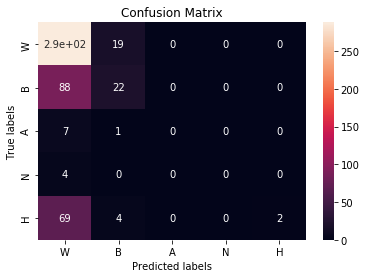

In [36]:
crossValidation = KFold(n_splits=10)
ourTree = RandomForestClassifier(n_estimators= rfrandom.best_params_['n_estimators'],max_depth= rfrandom.best_params_['max_depth'],random_state=0)
for train_fold, valid_fold in crossValidation.split(X_train):
    training = traindata.iloc[train_fold]
    testing = traindata.iloc[valid_fold]
    foldfit = ourTree.fit(X = training.drop(['race','name'], axis=1),
                               y = training["race"])
    modelscore = foldfit.score(X=testing.drop(['race','name'], axis=1),
                                    y=testing["race"])
test_predict = ourTree.predict(X_test)
confm = np.array(confusion_matrix(y_test,test_predict,labels=[1,2,3,4,6]))
conf_matrix= pd.DataFrame(confm, index=['W','B','A','N','H'],columns=['W','B','A','N','H'])
print(conf_matrix)

plt.figure(figsize=(6,4))
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [37]:
print(classification_report(y_test, test_predict))
print("Overall Accuracy of the model is :" ,accuracy_score(y_test, test_predict)*100, "%") 

              precision    recall  f1-score   support

           1       0.63      0.94      0.75       307
           2       0.48      0.20      0.28       110
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         4
           6       1.00      0.03      0.05        75

    accuracy                           0.62       504
   macro avg       0.42      0.23      0.22       504
weighted avg       0.64      0.62      0.53       504

Overall Accuracy of the model is : 61.904761904761905 %


### **4. Classification using K nearest neighbours classifier** 

K nearest algorithm is another supervised learning algorithm. It classifies new data based on its similarity measure to existing data. It classifies new data points based on how its K neighbours are classified. Here we choose the value of K as 10.

     W  B  A  N  H
W  306  1  0  0  0
B  110  0  0  0  0
A    8  0  0  0  0
N    4  0  0  0  0
H   75  0  0  0  0


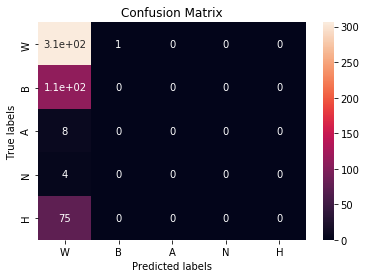

In [38]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

confm = np.array(confusion_matrix(y_test,y_pred,labels=[1,2,3,4,6]))
conf_matrix= pd.DataFrame(confm, index=['W','B','A','N','H'],columns=['W','B','A','N','H'])
print(conf_matrix)

plt.figure(figsize=(6,4))
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [39]:
print(classification_report(y_test, y_pred))
print("Overall Accuracy of the model is :" ,accuracy_score(y_test, y_pred)*100, "%") 

              precision    recall  f1-score   support

           1       0.61      1.00      0.76       307
           2       0.00      0.00      0.00       110
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        75

    accuracy                           0.61       504
   macro avg       0.12      0.20      0.15       504
weighted avg       0.37      0.61      0.46       504

Overall Accuracy of the model is : 60.71428571428571 %


#### **Conclusion**

#### **We notice that hyper paramater tuning for random forest increased our accuracy, to around 60% in comparison to just using decision tree which gave us an accuracy ranging between 50%-54%.** SVM produces a relatively good result with an accuracy of above 60%. KNN classifier produces almost the same accuracy as SVM. We notice that the pearsons correlation of the features with the target variable 'race' were relatively low. This means that our features were not the best predictors for 'race'. During the process of data cleaning, we also found that the training and testing data sets had a high number of missing values in the columns 'age', 'race', 'flee', 'armed'. The  other 4 data sets encountered an even high percentage of missing values, in comparison to the training and testing data sets. Even though we imputed the missing values using methods like interpolation , mean value, and mode, the presence of a high number of these values might have led to the low accuracy of the model